In [2]:
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import cell2location
import scvi


from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns
#定义分析结果保存在哪
results_folder = './results/lymph_nodes_analysis/'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

D:\Anaconda3\envs\cell2loc_env\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
D:\Anaconda3\envs\cell2loc_env\lib\site-packages\scvi_tools-1.0.3-py3.9.egg\scvi\_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
D:\Anaconda3\envs\cell2loc_env\lib\site-packages\scvi_tools-1.0.3-py3.9.egg\scvi\_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [3]:
#通过scanpy导入公开发表的淋巴结空间转录组数据
adata_vis = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

# rename genes to ENSEMBL
adata_vis.var['SYMBOL'] = adata_vis.var_names#_names:提取行名
adata_vis.var_names = adata_vis.var['gene_ids']
adata_vis.var_names.name = None#_names.name = None将名称设为无

D:\Anaconda3\envs\cell2loc_env\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
D:\Anaconda3\envs\cell2loc_env\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
D:\Anaconda3\envs\cell2loc_env\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()#传递了稀疏矩阵，但需要密集数据。使用X.toarray（）转换为密集的numpy数组
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

D:\Anaconda3\envs\cell2loc_env\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [5]:
# Download data if not already here
import os
if not os.path.exists('./data/sc.h5ad'):
    !cd ./data/ && wget https://cell2location.cog.sanger.ac.uk/paper/integrated_lymphoid_organ_scrna/RegressionNBV4Torch_57covariates_73260cells_10237genes/sc.h5ad

# Read data
adata_ref = sc.read(f'./data/sc.h5ad')

# Use ENSEMBL as gene IDs to make sure IDs are unique and correctly matched
adata_ref.var['SYMBOL'] = adata_ref.var.index
adata_ref.var.index = adata_ref.var['GeneID-2'].copy()
adata_ref.var_names = adata_ref.var['GeneID-2'].copy()
adata_ref.var.index.name = None
adata_ref.raw.var['SYMBOL'] = adata_ref.raw.var.index
adata_ref.raw.var.index = adata_ref.raw.var['GeneID-2'].copy()
adata_ref.raw.var.index.name = None

D:\Anaconda3\envs\cell2loc_env\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


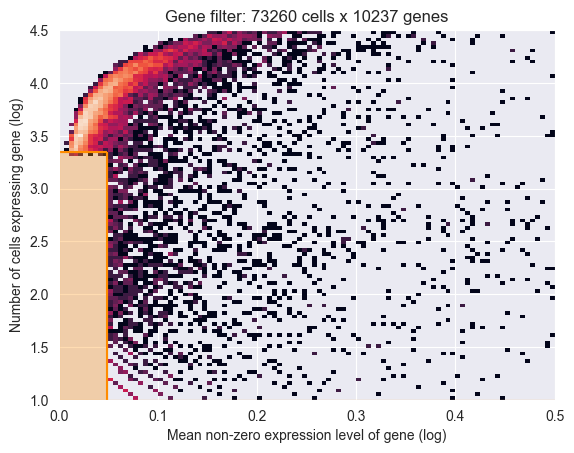

In [6]:
# before we estimate the reference cell type signature we recommend to perform very permissive genes selection
# in this 2D histogram orange rectangle lays over excluded genes.
# In this case, the downloaded dataset was already filtered using this method,
# hence no density under the orange rectangle
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

D:\Anaconda3\envs\cell2loc_env\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


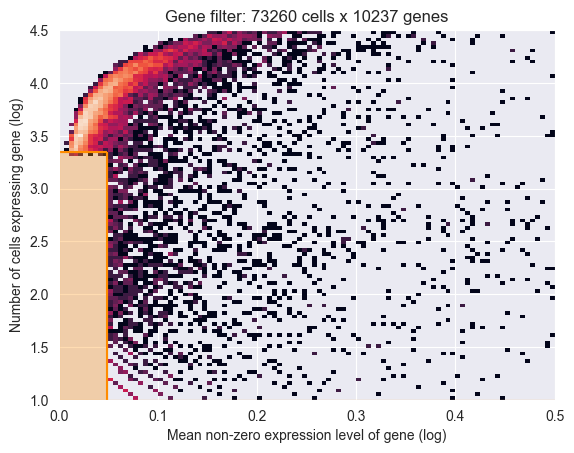

In [7]:
# before we estimate the reference cell type signature we recommend to perform very permissive genes selection
# in this 2D histogram orange rectangle lays over excluded genes.
# In this case, the downloaded dataset was already filtered using this method,
# hence no density under the orange rectangle
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

In [8]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='Sample',
                        # cell type, covariate used for constructing signatures
                        labels_key='Subset',
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        categorical_covariate_keys=['Method']
                       )

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [9]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.3.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'Sample',
│   'labels_key': 'Subset',
│   'categorical_covariate_keys': ['Method'],
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  23   │
│         n_cells          │ 73260 │
│ n_extra_categorical_covs │   1   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  34   │
│          n_vars          │ 10237 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         ind_x          │           adata.obs['_indices']            │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                         batch State Registry                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃       Categories       ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Sample'] │    4861STDY7135913     │          0          │
│                     │    4861STDY7135914     │          1          │
│                     │    4861STDY7208412     │          2          │
│                     │    4861STDY7208413     │          3          │
│                     │    4861STDY7462253     │          4          │
│                     │    4861STDY7462254     │          5          │
│                     │    4861STDY7462255     │          6          │
│                     │    4861STDY7462256     │          7          │
│                     │    4861STDY7528597     │          8          │
│                     │    4861STDY7528598     │          9          │
│                     │    4861STDY7528599     │         10          │
│                     │    4861STDY7528600     │         11          │
│                     │      BCP002_Total      │         12          │
│                     │      BCP003_Total      │         13          │
│                     │      BCP004_Total      │         14          │
│                     │      BCP005_Total      │         15          │
│                     │      BCP006_Total      │         16          │
│                     │      BCP008_Total      │         17          │
│                     │      BCP009_Total      │         18          │
│                     │ Human_colon_16S7255677 │         19          │
│                     │ Human_colon_16S7255678 │         20          │
│                     │ Human_colon_16S8000484 │         21          │
│                     │      Pan_T7935494      │         22          │
└─────────────────────┴────────────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Subset'] │    B_Cycling     │          0          │
│                     │     B_GC_DZ      │          1          │
│                     │     B_GC_LZ      │          2          │
│                     │    B_GC_prePB    │          3          │
│                     │      B_IFN       │          4          │
│                     │   B_activated    │          5          │
│                     │      B_mem       │          6          │
│                     │     B_naive      │          7          │
│                     │     B_plasma     │          8          │
│                     │     B_preGC      │          9          │
│                     │     DC_CCR7+     │         10          │
│                     │     DC_cDC1      │         11          │
│                     │     DC_cDC2      │         12          │
│                     │      DC_pDC      │         13          │
│                     │       Endo       │         14          │
│                     │       FDC        │         15          │
│                     │       ILC        │         16          │
│                     │  Macrophages_M1  │         17          │
│                     │  Macrophages_M2  │         18          │
│                     │       Mast       │         19          │
│                     │    Monocytes     │         20          │
│                     │        NK        │         21          │
│                     │       NKT        │         22          │
│                     │      T_CD4+      │         23          │
│                     │    T_CD4+_TfH    │         24          │
│                     │  T_CD4+_TfH_GC   │         25          │
│                     │   T_CD4+_naive   │         26          │
│                     │  T_CD8+_CD161+   │         27          │
│                     │ T_CD8+_cytotoxic │         28          │
│                     │   T_CD8+_naive   │         29          │
│                     │     T_TIM3+      │         30          │
│                     │      T_TfR       │         31          │
│                     │      T_Treg      │         32          │
│                     │       VSMC       │         33          │
└─────────────────────┴──────────────────┴─────────────────────┘

          extra_categorical_covs State Registry           
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Method'] │    3GEX    │          0          │
│                     │    5GEX    │          1          │
│                     │            │                     │
└─────────────────────┴────────────┴─────────────────────┘

In [10]:
from pytorch_lightning import Trainer
Trainer(accelerator='cuda')
mod.train(max_epochs=250, use_gpu=True)         

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
D:\Anaconda3\envs\cell2loc_env\lib\site-packages\pytorch_lightning-2.1.0rc0-py3.9.egg\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
D:\Anaconda3\envs\cell2loc_env\lib\site-packages\scvi_tools-1.0.3-py3.9.egg\scvi\train\_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator,

Epoch 250/250: 100%|██████████| 250/250 [48:17<00:00, 14.57s/it, v_num=1, elbo_train=2.88e+8]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████| 250/250 [48:17<00:00, 11.59s/it, v_num=1, elbo_train=2.88e+8]


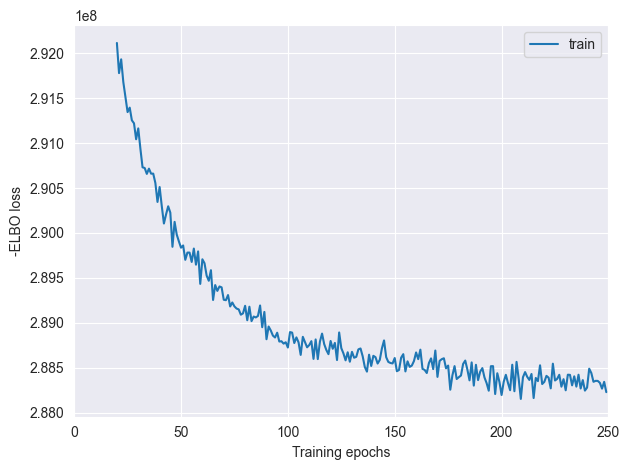

In [11]:
mod.plot_history(20)

In [12]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

D:\Anaconda3\envs\cell2loc_env\lib\site-packages\scvi_tools-1.0.3-py3.9.egg\scvi\model\base\_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|██████████| 999/999 [00:51<00:00, 19.25it/s]


'./results/lymph_nodes_analysis//reference_signatures/sc.h5ad'

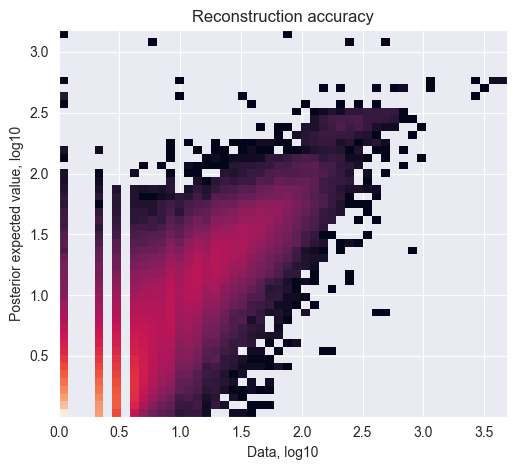

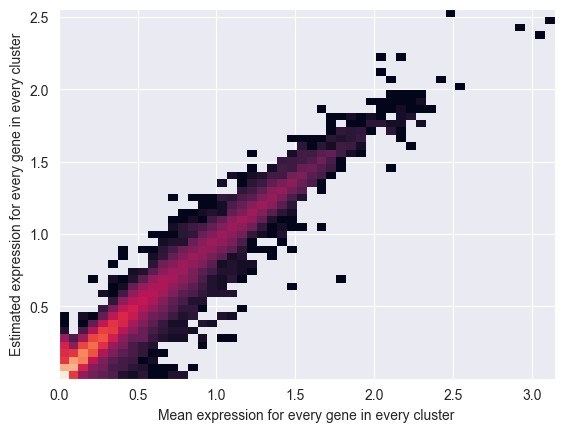

In [13]:
mod.plot_QC()

In [14]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]


B_Cycling   B_GC_DZ   B_GC_LZ  B_GC_prePB     B_IFN
ENSG00000188976   0.434540  0.244096  0.312674    0.353862  0.154429
ENSG00000188290   0.002172  0.000678  0.000787    0.055943  0.041586
ENSG00000187608   0.388674  0.214782  0.276392    0.508719  3.950327
ENSG00000186891   0.020394  0.000866  0.055953    0.069861  0.009267
ENSG00000186827   0.007710  0.000558  0.006440    0.031860  0.011856

In [15]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

D:\Anaconda3\envs\cell2loc_env\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [16]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.3.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 4035  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 10217 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                       batch State Registry                        
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃     Categories      ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ V1_Human_Lymph_Node │          0          │
└─────────────────────┴─────────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

D:\Anaconda3\envs\cell2loc_env\lib\site-packages\scvi_tools-1.0.3-py3.9.egg\scvi\train\_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
D:\Anaconda3\envs\cell2loc_env\lib\site-packages\lightning-2.0.9-py3.9.egg\lightning\pytorch\trainer\configuration_validator.py:69: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
D:\Anaconda3\envs\cell2loc_env\lib\site-packages\lightning-2.0.9-py3.9.egg\lightning\pytorch\loops\fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller t

Epoch 30000/30000: 100%|██████████| 30000/30000 [2:11:08<00:00,  5.82it/s, v_num=1, elbo_train=4.54e+7]  

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|██████████| 30000/30000 [2:11:08<00:00,  3.81it/s, v_num=1, elbo_train=4.54e+7]


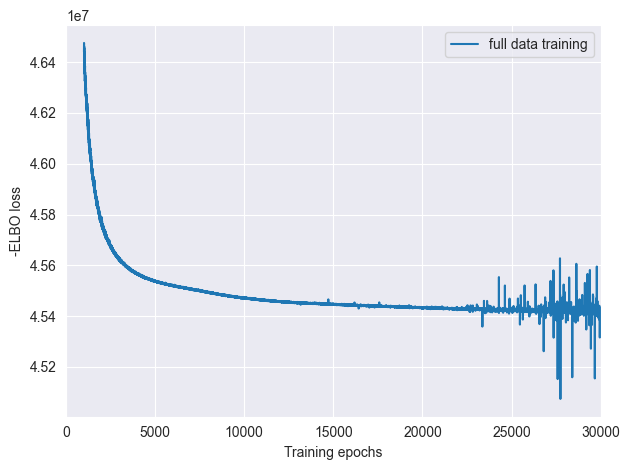

In [17]:
mod.train(max_epochs=30000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True,
         )

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [18]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

D:\Anaconda3\envs\cell2loc_env\lib\site-packages\scvi_tools-1.0.3-py3.9.egg\scvi\model\base\_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|██████████| 999/999 [01:25<00:00, 11.64it/s]


'./results/lymph_nodes_analysis//cell2location_map/sp.h5ad'

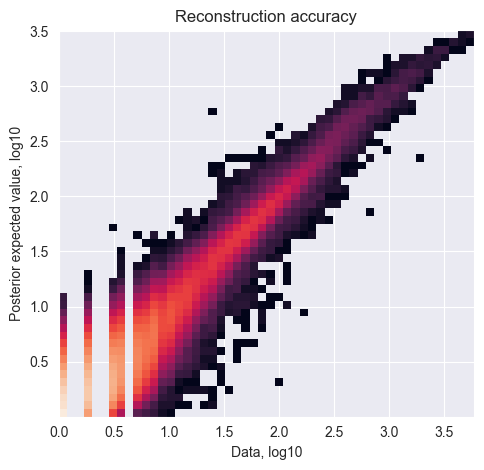

In [20]:
mod.plot_QC()

D:\Anaconda3\envs\cell2loc_env\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
D:\Anaconda3\envs\cell2loc_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


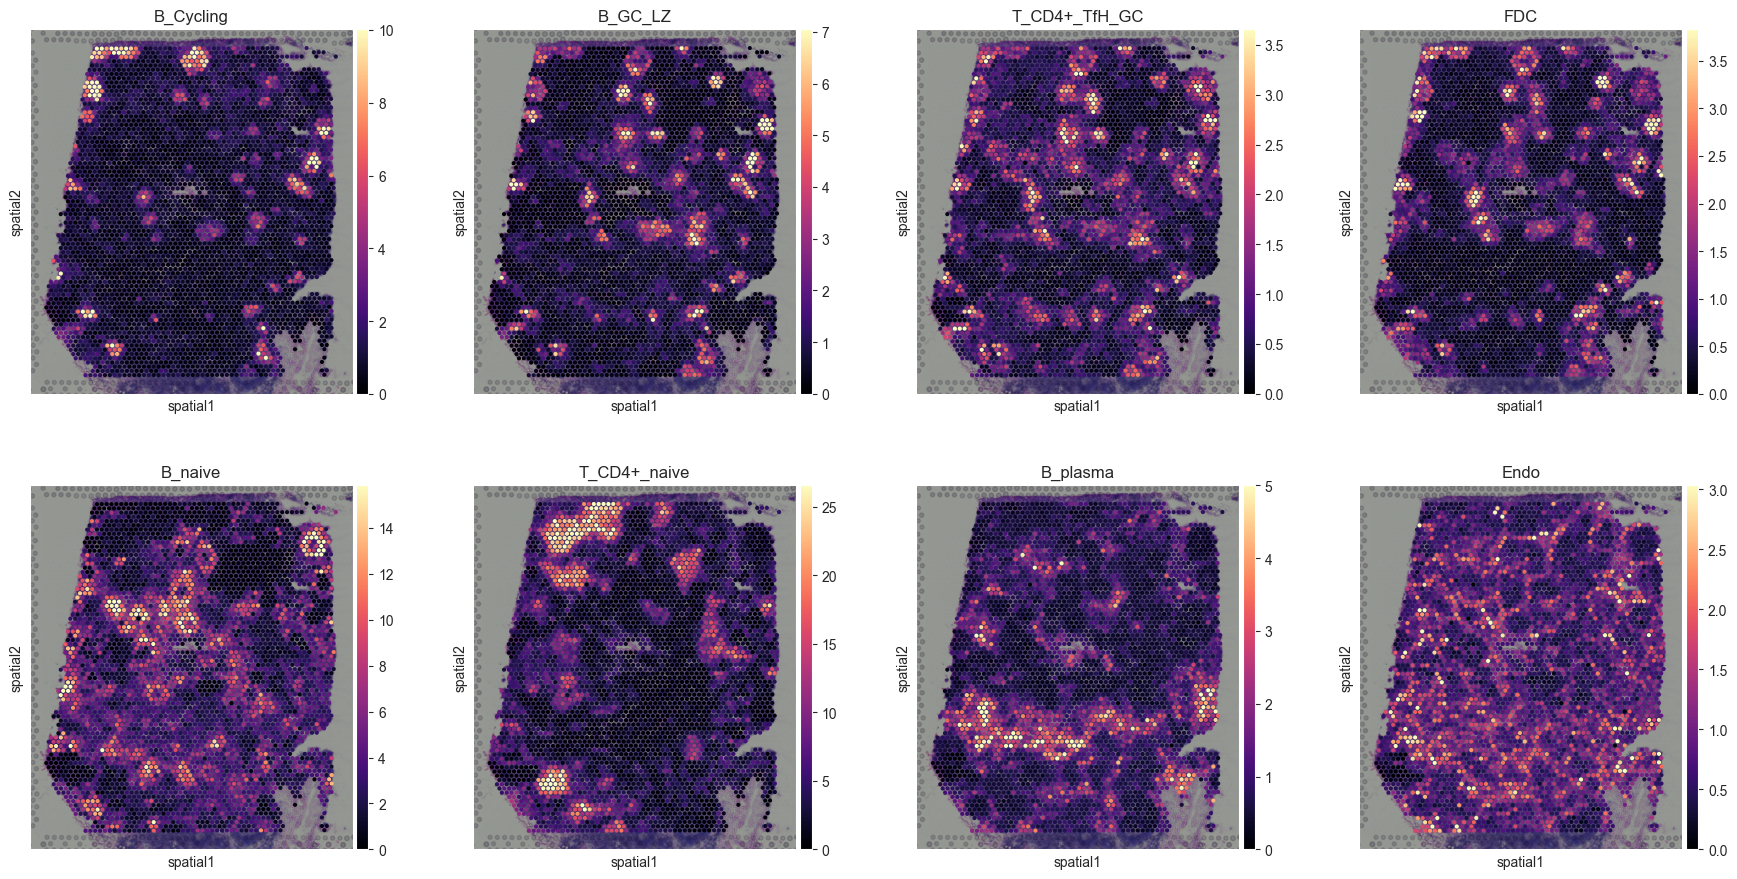

In [21]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# select one slide
from cell2location.utils import select_slide
slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(slide, cmap='magma',
                  # show first 8 cell types
                  color=['B_Cycling', 'B_GC_LZ', 'T_CD4+_TfH_GC', 'FDC',
                         'B_naive', 'T_CD4+_naive', 'B_plasma', 'Endo'],
                  ncols=4, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2'
                 )

In [22]:
# compute KNN using the cell2location output stored in adata.obsm
sc.pp.neighbors(adata_vis, use_rep='q05_cell_abundance_w_sf',
                n_neighbors = 15)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=1.1)

# add region as categorical variable
adata_vis.obs["region_cluster"] = adata_vis.obs["leiden"].astype("category")

D:\Anaconda3\envs\cell2loc_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
D:\Anaconda3\envs\cell2loc_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
D:\Anaconda3\envs\cell2loc_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


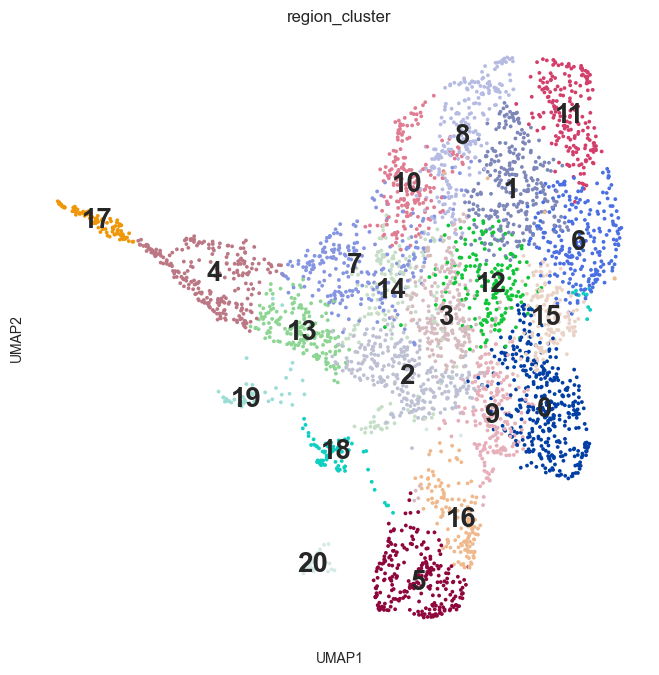

D:\Anaconda3\envs\cell2loc_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
D:\Anaconda3\envs\cell2loc_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
D:\Anaconda3\envs\cell2loc_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


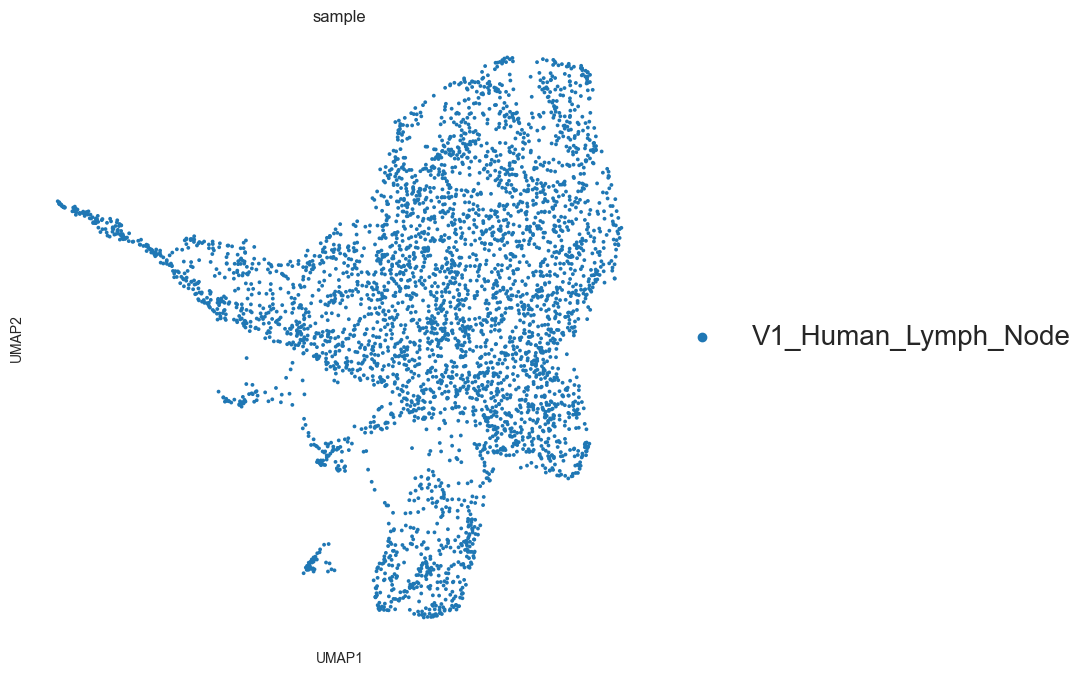

D:\Anaconda3\envs\cell2loc_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
D:\Anaconda3\envs\cell2loc_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


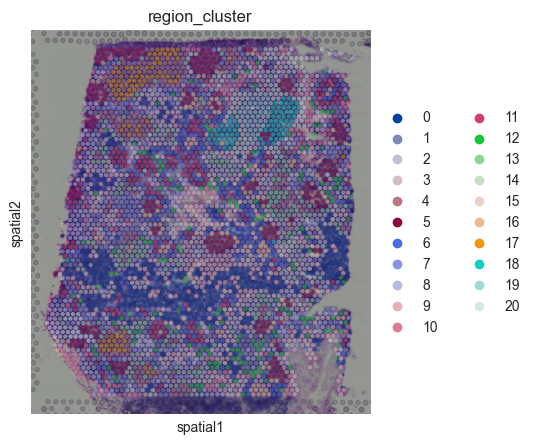

In [23]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)

# show regions in UMAP coordinates
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [8, 8]}):
    sc.pl.umap(adata_vis, color=['region_cluster'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20)
    sc.pl.umap(adata_vis, color=['sample'], size=30,
               color_map = 'RdPu', ncols = 2,
               legend_fontsize=20)

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    sc.pl.spatial(adata_vis, color=['region_cluster'],
                  size=1.3, img_key='hires', alpha=0.5)

In [24]:
from cell2location import run_colocation
res_dict, adata_vis = run_colocation(
    adata_vis,
    model_name='CoLocatedGroupsSklearnNMF',
    train_args={
      'n_fact': np.arange(11, 13), # IMPORTANT: use a wider range of the number of factors (5-30)
      'sample_name_col': 'sample', # columns in adata_vis.obs that identifies sample
      'n_restarts': 3 # number of training restarts
    },
    # the hyperparameters of NMF can be also adjusted:
    model_kwargs={'alpha': 0.01, 'init': 'random', "nmf_kwd_args": {"tol": 0.000001}},
    export_args={'path': f'{run_name}/CoLocatedComb/'}
)

### Analysis name: CoLocatedGroupsSklearnNMF_11combinations_4035locations_34factors


D:\Anaconda3\envs\cell2loc_env\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
D:\Anaconda3\envs\cell2loc_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


### Analysis name: CoLocatedGroupsSklearnNMF_12combinations_4035locations_34factors


D:\Anaconda3\envs\cell2loc_env\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
D:\Anaconda3\envs\cell2loc_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


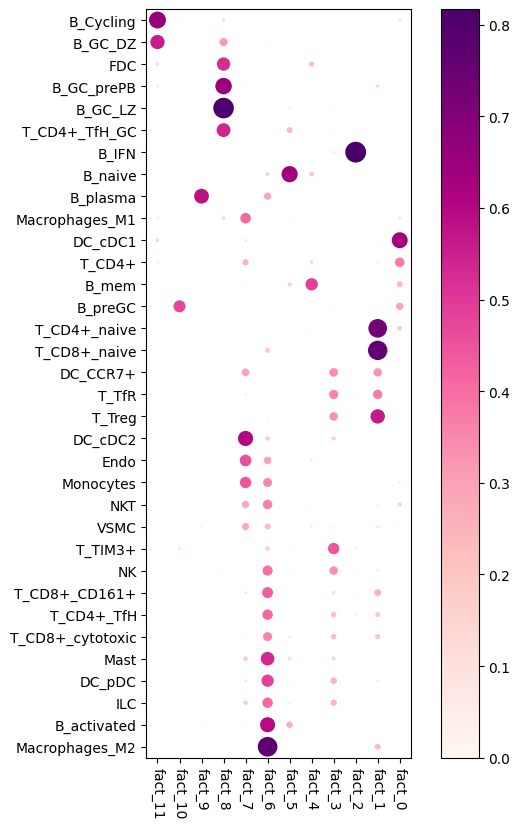

In [25]:
# Here we plot the NMF weights (Same as saved to `cell_type_fractions_heatmap`)
res_dict['n_fact12']['mod'].plot_cell_type_loadings()

In [26]:
# Compute expected expression per cell type
expected_dict = mod.module.model.compute_expected_per_cell_type(
    mod.samples["post_sample_q05"], mod.adata_manager
)

# Add to anndata layers
for i, n in enumerate(mod.factor_names_):
    adata_vis.layers[n] = expected_dict['mu'][i]

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

'./results/lymph_nodes_analysis//cell2location_map/sp.h5ad'

D:\Anaconda3\envs\cell2loc_env\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
D:\Anaconda3\envs\cell2loc_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
D:\Anaconda3\envs\cell2loc_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
D:\Anaconda3\envs\cell2loc_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

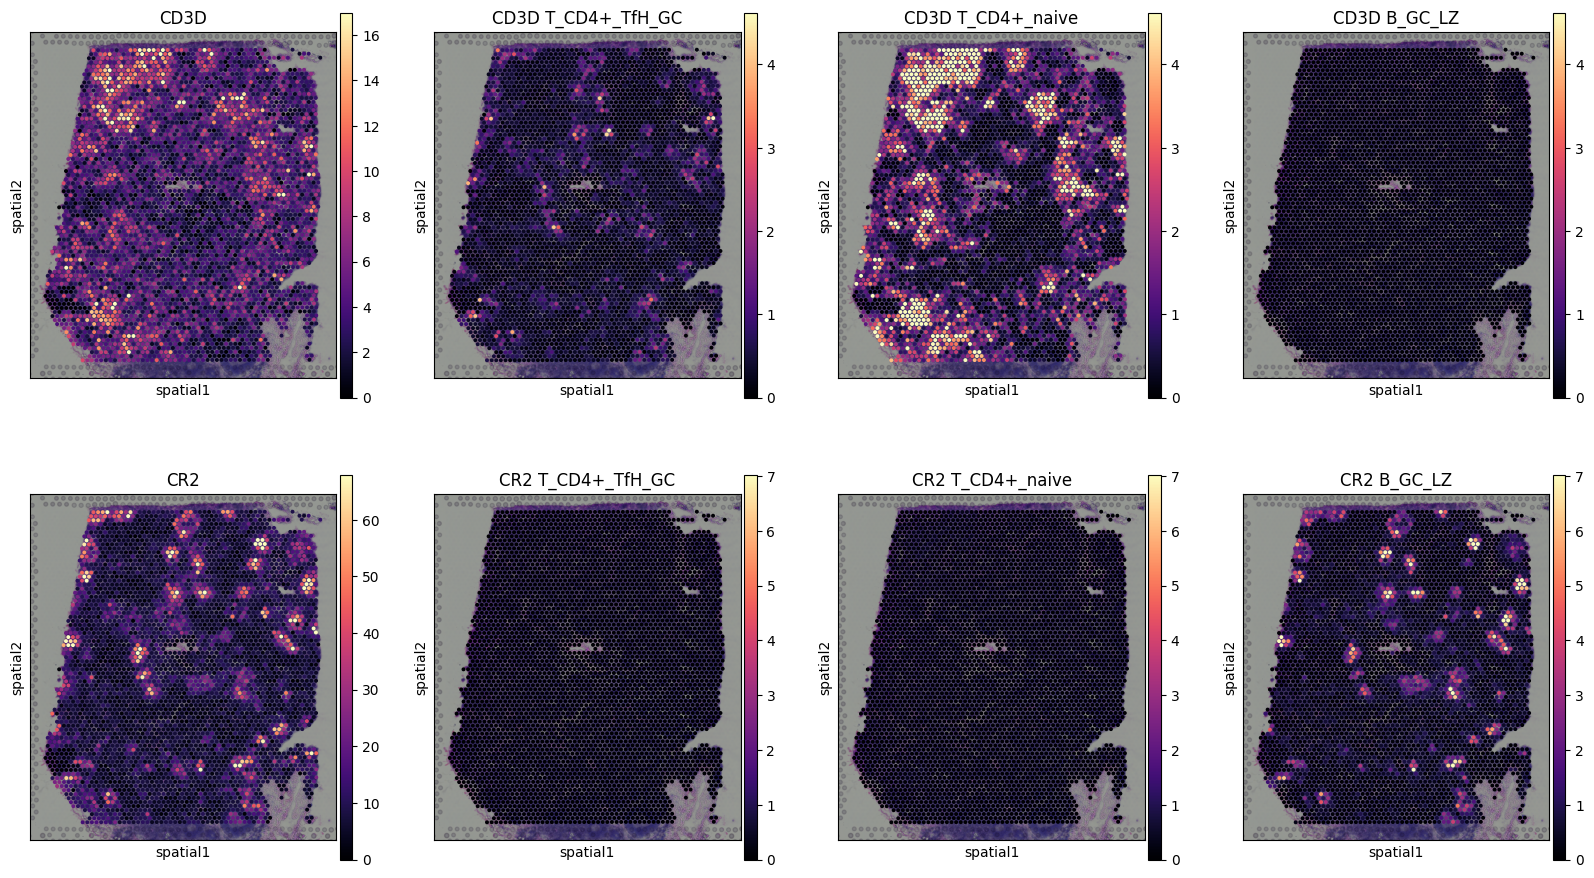

In [27]:
# list cell types and genes for plotting
ctypes = ['T_CD4+_TfH_GC', 'T_CD4+_naive', 'B_GC_LZ']
genes = ['CD3D', 'CR2']

with mpl.rc_context({'axes.facecolor':  'black'}):
    # select one slide
    slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')

    from tutorial_utils import plot_genes_per_cell_type
    plot_genes_per_cell_type(slide, genes, ctypes)

In [28]:
# Get posterior distribution samples for specific variables
samples_w_sf = mod.sample_posterior(num_samples=1000, use_gpu=True, return_samples=True,
                                    batch_size=2020,
                                    return_sites=['w_sf', 'm_g', 'u_sf_mRNA_factors'])
# samples_w_sf['posterior_samples'] contains 1000 samples as arrays with dim=(num_samples, ...)
samples_w_sf['posterior_samples']['w_sf'].shape

D:\Anaconda3\envs\cell2loc_env\lib\site-packages\scvi_tools-1.0.3-py3.9.egg\scvi\model\base\_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|██████████| 999/999 [00:46<00:00, 21.45it/s]


(1000, 4035, 34)

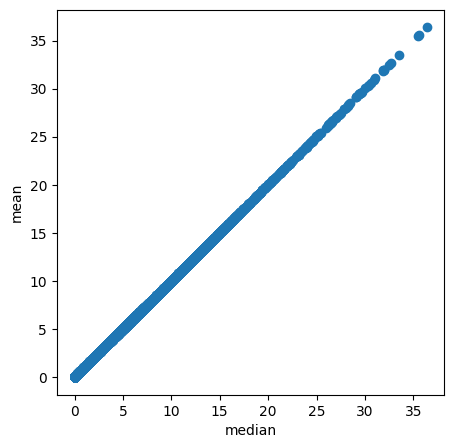

In [30]:
# Compute any quantile of the posterior distribution
medians = mod.posterior_quantile(q=0.5, batch_size=mod.adata.n_obs)

with mpl.rc_context({'axes.facecolor':  'white', 'figure.figsize': [5, 5]}):
    plt.scatter(medians['w_sf'].flatten(), mod.samples['post_sample_means']['w_sf'].flatten())
    plt.xlabel('median')
    plt.ylabel('mean')

In [31]:
cell2location.utils.list_imported_modules()

sys 3.9.18 (main, Sep 11 2023, 14:09:26) [MSC v.1916 64 bit (AMD64)]
re 2.2.1
ipykernel._version 6.25.0
json 2.0.9
jupyter_client._version 7.4.9
traitlets._version 5.7.1
traitlets 5.7.1
logging 0.5.1.2
zlib 1.0
platform 1.0.8
zmq.sugar.version 23.2.0
zmq.sugar 23.2.0
zmq 23.2.0
tornado 6.3.2
_ctypes 1.1.0
ctypes 1.1.0
colorama 0.4.6
socketserver 0.4
argparse 1.1
dateutil._version 2.8.2
dateutil 2.8.2
six 1.16.0
_decimal 1.70
decimal 1.70
jupyter_core.version 5.3.0
jupyter_core 5.3.0
platformdirs.version 3.10.0
platformdirs 3.10.0
entrypoints 0.4
jupyter_client 7.4.9
ipykernel 6.25.0
IPython.core.release 8.15.0
executing.version 0.8.3
executing 0.8.3
pure_eval.version 0.2.2
pure_eval 0.2.2
stack_data.version 0.2.0
stack_data 0.2.0
pygments 2.15.1
IPython.core.crashhandler 8.15.0
pickleshare 0.7.5
backcall 0.2.0
decorator 5.1.1
_sqlite3 2.6.0
sqlite3.dbapi2 2.6.0
sqlite3 2.6.0
exceptiongroup._version 1.0.4
exceptiongroup 1.0.4
wcwidth 0.2.5
prompt_toolkit 3.0.36
parso 0.8.3
jedi 0.18.1
u

In [32]:
cell2location.__version__

'0.1.4'